In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
# ! pip install pgmpy

In [33]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
import pandas as pd
import numpy as np

import common

In [35]:
date_set_path = "../temp_sets_100/"

# icustays

## Read samples

In [36]:
icustays_df = common.read_csv_no_rowid(date_set_path+"icustays.csv")

In [37]:
icustays_df['icustay_id'].value_counts()

271533    1
266628    1
238979    1
214885    1
259374    1
         ..
223212    1
297492    1
222646    1
232008    1
237653    1
Name: icustay_id, Length: 124, dtype: int64

## Data preproces

In [38]:
# Drop useless colums
icustays_df.drop(['los'], axis=1, inplace=True)

### Process null values

In [39]:
# Check null value in table
common.nan_count(icustays_df)

Total columns: 10
Total rows: 124
--------------
subject_id        0
hadm_id           0
icustay_id        0
dbsource          0
first_careunit    0
last_careunit     0
first_wardid      0
last_wardid       0
intime            0
outtime           0
dtype: int64


### Set the column types

In [40]:
icustays_df.dtypes

subject_id         int64
hadm_id            int64
icustay_id         int64
dbsource          object
first_careunit    object
last_careunit     object
first_wardid       int64
last_wardid        int64
intime            object
outtime           object
dtype: object

In [41]:
# Transfer some date type
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [42]:
icustays_df.dtypes

subject_id                 int64
hadm_id                    int64
icustay_id                 int64
dbsource                  object
first_careunit            object
last_careunit             object
first_wardid               int64
last_wardid                int64
intime            datetime64[ns]
outtime           datetime64[ns]
dtype: object

### Process time value

In [43]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

In [44]:
admittime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [45]:
icustays_mid_df = pd.merge(left=icustays_df, right=admittime_df, how='left', on=['hadm_id'])

In [47]:
icustays_mid_df['outtime'] = icustays_mid_df.apply(common.time_process, args=('intime', 'outtime'), axis=1)
icustays_mid_df['intime'] = icustays_mid_df.apply(common.time_process, args=('admittime', 'intime'), axis=1)

In [48]:
icustays_df = icustays_mid_df.drop(['subject_id', 'hadm_id', 'admittime'], axis=1)

---

##  Build Network

In [49]:
from sdv.tabular import CTGAN
from sdv.constraints import create_custom_constraint

In [50]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

### Set constraint

In [51]:
def time_is_valid(column_names, data):
    intime_outtime = ((data['outtime'] - data['intime']).apply(lambda x: 0 <= x.days  <= 365))
    
    return intime_outtime

def time_trasform(column_names, data):
    # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
    return data

def time_reverse_transform(column_names, transformed_data):
    transformed_data['intime'] = pd.to_datetime(transformed_data['intime'])
    transformed_data['outtime'] = pd.to_datetime(transformed_data['outtime'])

    return transformed_data

In [52]:
TimeProcess = create_custom_constraint(
    is_valid_fn=time_is_valid,
    transform_fn=time_trasform,
    reverse_transform_fn=time_reverse_transform
)

time_constraint = TimeProcess(
    column_names=['intime', 'outtime']
)

In [53]:
from sdv.constraints import Unique

unique_icustay_id_constraint = Unique(
    column_names=['icustay_id']
)

In [54]:
constrains = [unique_icustay_id_constraint]

### Build and train model

In [55]:
model = CTGAN(
    constraints=constrains, 
    # generator_lr=0.0005,
    batch_size=100,
    cuda=True, 
    verbose=True, 
    epochs=100)

In [56]:
len(icustays_df)

124

In [57]:
train_data = icustays_df
model.fit(train_data)

Epoch 1, Loss G:  1.4536,Loss D: -0.0086
Epoch 2, Loss G:  1.4573,Loss D:  0.0033
Epoch 3, Loss G:  1.4661,Loss D:  0.0181
Epoch 4, Loss G:  1.4718,Loss D: -0.0387
Epoch 5, Loss G:  1.3191,Loss D: -0.0296
Epoch 6, Loss G:  1.4645,Loss D: -0.0357
Epoch 7, Loss G:  1.4739,Loss D: -0.0949
Epoch 8, Loss G:  1.4334,Loss D: -0.1250
Epoch 9, Loss G:  1.4449,Loss D: -0.0683
Epoch 10, Loss G:  1.4761,Loss D: -0.0564
Epoch 11, Loss G:  1.4996,Loss D: -0.1011
Epoch 12, Loss G:  1.3574,Loss D: -0.1581
Epoch 13, Loss G:  1.4021,Loss D: -0.1964
Epoch 14, Loss G:  1.3539,Loss D: -0.1613
Epoch 15, Loss G:  1.3624,Loss D: -0.2537
Epoch 16, Loss G:  1.3329,Loss D: -0.2197
Epoch 17, Loss G:  1.3336,Loss D: -0.1525
Epoch 18, Loss G:  1.3593,Loss D: -0.2280
Epoch 19, Loss G:  1.2920,Loss D: -0.1282
Epoch 20, Loss G:  1.3608,Loss D: -0.1763
Epoch 21, Loss G:  1.5088,Loss D: -0.0867
Epoch 22, Loss G:  1.2076,Loss D: -0.2957
Epoch 23, Loss G:  1.2848,Loss D: -0.2939
Epoch 24, Loss G:  1.3413,Loss D: -0.0608
E

In [58]:
import cloudpickle

with open(date_set_path + "100_models/" + "icustays_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [59]:
# model.save(date_set_path + "100_models/" + "icustays_model.pkl")

In [60]:
sample = model.sample(100)

Sampling rows: 100%|██████████| 100/100 [00:00<00:00, 1747.23it/s]


In [61]:
sample['icustay_id'].value_counts()

201891    1
244456    1
273869    1
220218    1
255756    1
         ..
289426    1
224507    1
282084    1
281177    1
242456    1
Name: icustay_id, Length: 100, dtype: int64

In [62]:
sample.head()

,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,201891,metavision,CCU,CCU,7,7,10311.0,3120.0
1,204065,carevue,MICU,TSICU,7,11,40270.0,3120.0
2,247332,carevue,MICU,CCU,7,19,31.0,129627.0
3,209591,metavision,CCU,TSICU,22,57,31.0,3120.0
4,243804,metavision,MICU,NICU,14,45,31.0,46780.0


---

## Evaluate data

In [63]:
from sdv.evaluation import evaluate

In [64]:
train_data.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

In [65]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4458508691491972

In [66]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.2964071617205636

In [67]:
sample['dbsource'].value_counts()

carevue       56
metavision    44
Name: dbsource, dtype: int64

<AxesSubplot:>

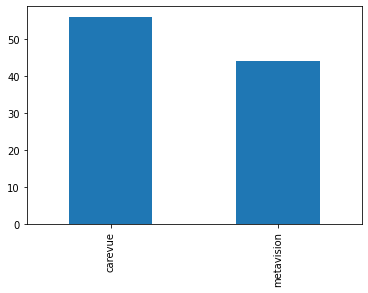

In [68]:
sample['dbsource'].value_counts().plot.bar()

In [69]:
train_data['dbsource'].value_counts()

carevue       72
metavision    52
Name: dbsource, dtype: int64

<AxesSubplot:>

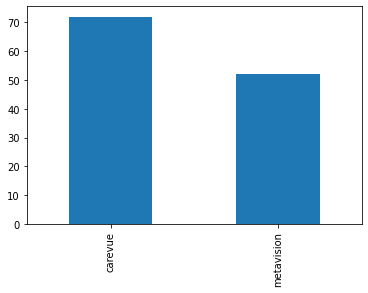

In [70]:
train_data['dbsource'].value_counts().plot.bar()